In [3]:
# %load oblig_1_ex_1.py
from dolfin import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

class Right(SubDomain):
    def inside(self, x, on_boundary, eps=1.e-14):
        return x[0] > 1 - eps


class Left(SubDomain):
    def inside(self, x, on_boundary, eps=1.e-14):
        return x[0] < eps


def solver_prob_1(N=8, deg=1, k=1):
    mesh = UnitSquareMesh(N, N)
    V = FunctionSpace(mesh, 'P', deg)

    #numerical and analytical expressions
    u_e = Expression('sin(pi*k*x[0])*cos(pi*k*x[1])', degree=deg, k=k)
    u_num = Function(V)

    #Boundary conditions
    bcs = [DirichletBC(V, Constant(0.0), Left()),
           DirichletBC(V, Constant(1.0), Right())]

    u = TrialFunction(V)
    v = TestFunction(V)

    f = Constant(1.0)
    a = dot(grad(u), grad(v)) * dx
    L = f * v * dx

    u = Function(V)
    solve(a == L, u, bcs)
    
    return mesh, u, V


def solver_prob_2(N=8, mu=1, deg=1, galerkin=False):
    
    mesh = UnitSquareMesh(N, N)
    V = FunctionSpace(mesh, 'P', deg)
    u_num = Function(V)
    
    bcs = [
        DirichletBC(V, Constant(0.0), Left()),
        DirichletBC(V, Constant(1.0), Right()),
    ]
    
    u = TrialFunction(V)
    v = TestFunction(V)
    
    if galerkin:
        beta = 0.5 * mesh.hmin()
        v  = v + beta * v.dx(0)
    
    f = Constant(0.0)
    g = Constant(1.0)    
    
    a = mu * inner(grad(u), grad(v)) * dx + u.dx(0) * v * dx
    L = f * v * dx + g * v * ds
    
    solve(a==L, u_num, bcs)
    
    return u_num, V, mesh


def error_fit(L_2, H_1):
    N = L_2.index.values
    param = L_2.columns.values
    best_fit_coeffs = pd.DataFrame(index=param, columns=['alpha', 'C_alpha', 'beta', 'C_beta'])
    h_log = [np.log(1.0 / n) for n in N]
    L_2_log = L_2.applymap(np.log)
    H_1_log = H_1.applymap(np.log)
    
    for p in param:
        L_2_fit = np.polyfit(h_log, L_2_log[p], deg=1)
        H_1_fit = np.polyfit(h_log, H_1_log[p], deg=1)
        
        L_2_fit[1] = np.exp(L_2_fit[1])
        H_1_fit[1] = np.exp(H_1_fit[1])
    
        best_fit_coeffs.loc[p] = list(L_2_fit) + list(H_1_fit)

    return best_fit_coeffs   

    
def prob_1(deg=1):
    
    N = [8, 16, 32, 64]
    freqs = [1, 2, 4,8]
    L_2_error = pd.DataFrame(index=N, columns=freqs)
    L_inf_error = pd.DataFrame(index=N, columns=freqs)
    H_1_error = pd.DataFrame(index=N, columns=freqs)
    
    
    for n in N:
        for freq in freqs:
                mesh,u_num,V = solver_prob_1(N=n, deg=deg, k=freq)
                u_ex = Expression('sin(k*pi*x[0])*cos(k*pi*x[1])', k=freq, degree=deg) 
                
                L_2 = errornorm(u_ex, u_num, 'l2', degree_rise=1)
                H_1 = errornorm(u_ex, u_num, 'H1', degree_rise=1)

                u_ex_values = interpolate(u_ex, V)
                u_ex_vector = u_ex_values.vector()
                u_num_vector = u_num.vector()
                L_inf = max(np.abs(u_ex_vector - u_num_vector))

                L_2_error.at[n, freq] = L_2
                L_inf_error.at[n, freq] = L_inf
                H_1_error.at[n, freq] = H_1
    
    
    print('----- problem 1 - part b -------' + '\n')
    print('L2 error norm' + '\n')
    display(L_2_error)
    print('L_inf error norm' + '\n')
    display(L_inf_error)
    print('H1 error norm' + '\n')
    display(H_1_error)
    print('\n\n\n')
    print('----- problem 1 - part c -------' + '\n')
    print('Best fit parameters')
    display(error_fit(L_2_error, H_1_error))
    
    #plot highest accuracy mesh and u  
    if deg > 1:
        p = plot(u_num)
        p.set_cmap('plasma')
        p.set_clim(0.0, 1.0)
        plt.title('u solution')
        plt.colorbar(p)
        plt.show()

        
def prob_2(deg=1, galerkin=False):
    mu_values = [0.1, 0.3, 1.0]
    N = [8, 16, 32, 64]

    L_2_error = pd.DataFrame(index=N, columns=mu_values)
    L_inf_error = pd.DataFrame(index=N, columns=mu_values)
    H_1_error = pd.DataFrame(index=N, columns=mu_values)
    
    for mu in mu_values:
        for n in N:
            u_num, V, omega = solver_prob_2(N=n, mu=mu, deg=deg, galerkin=galerkin)
            u_ex = Expression('(exp(1 / mu * x[0]) - 1) / (exp(1 / mu) - 1)', mu=mu, degree=deg)

            L_2 = errornorm(u_ex, u_num, 'L2', degree_rise=3)
            H_1 = errornorm(u_ex, u_num, 'H1', degree_rise=3)
            u_ex_values = interpolate(u_ex, V)
            u_ex_vector = u_ex_values.vector()
            u_num_vector = u_num.vector()
            L_inf = max(np.abs(u_ex_vector - u_num_vector))
            
            L_2_error.at[n, mu] = L_2
            L_inf_error.at[n, mu] = L_inf
            H_1_error.at[n, mu] = H_1
            
    print('----- problem 2 - part b -------' + '\n')
    print('L2 error norm' + '\n')
    display(L_2_error)
    print('L_inf error norm' + '\n')
    display(L_inf_error)
    print('H1 error norm' + '\n')
    display(H_1_error)
    print('\n\n\n')
    print('----- problem 2 - part c -------' + '\n')
    print('Best fit parameters')
    display(error_fit(L_2_error, H_1_error))
            
    if deg > 1:
        p = plot(u_num)
        p.set_cmap('plasma')
        p.set_clim(0.0, 1.0)
        plt.title('u solution')
        plt.colorbar(p)
        plt.show()      

    

In [ ]:
prob_1()

In [ ]:
prob_1(2)

----- problem 2 - part b -------

L2 error norm



,0.1,0.3,1.0
8,1.03411,0.553789,0.188002
16,1.03393,0.553768,0.187999
32,1.03391,0.553767,0.187998
64,1.03391,0.553767,0.187998


L_inf error norm



,0.1,0.3,1.0
8,2.86029,1.25308,0.403706
16,2.85817,1.25275,0.40427
32,2.8579,1.25272,0.404269
64,2.8582,1.25274,0.40434


H1 error norm



,0.1,0.3,1.0
8,6.40056,2.50335,0.785551
16,6.41341,2.50671,0.786512
32,6.41642,2.50754,0.786751
64,6.41715,2.50775,0.786811






----- problem 2 - part c -------

Best fit parameters


,alpha,C_alpha,beta,C_beta
0.1,8.32523e-05,1.03423,-0.00118828,6.38816
0.3,1.7706e-05,0.553803,-0.000808162,2.50003
1.0,9.47594e-06,0.188005,-0.000737291,0.7846


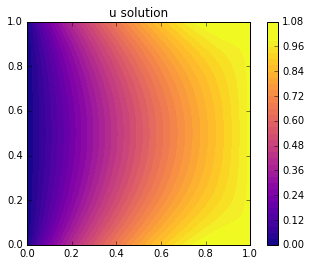

In [4]:
prob_2(2)